# **Imports and Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!cp drive/MyDrive/HFT_Researcher_Assessment/D1_Project_train.csv .
!cp drive/MyDrive/HFT_Researcher_Assessment/D1_Project_test.csv .
!pip install catboost

In [ ]:
# Import Packages (pretty standard stuff)
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Stuff
from sklearn import utils
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, accuracy_score
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from tensorflow import keras
from keras import layers, Sequential

# Saving Trained Models
import os
import joblib

# Disable Nonsense Output
import warnings
warnings.filterwarnings('ignore')

# **Data Loading and Exploration**

In [ ]:
# Load train dataset into pandas
train_data = pd.read_csv("D1_Project_train.csv")
X_train    = train_data.drop(labels = "TARGET", axis = 1, inplace = False)
y_train    = train_data["TARGET"]

# Load train dataset into pandas
test_data  = pd.read_csv("D1_Project_test.csv")
X_test     = test_data.drop(labels  = "TARGET", axis = 1, inplace = False)
y_test     = test_data["TARGET"]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(90000, 67) (90000,) (19707, 67) (19707,)


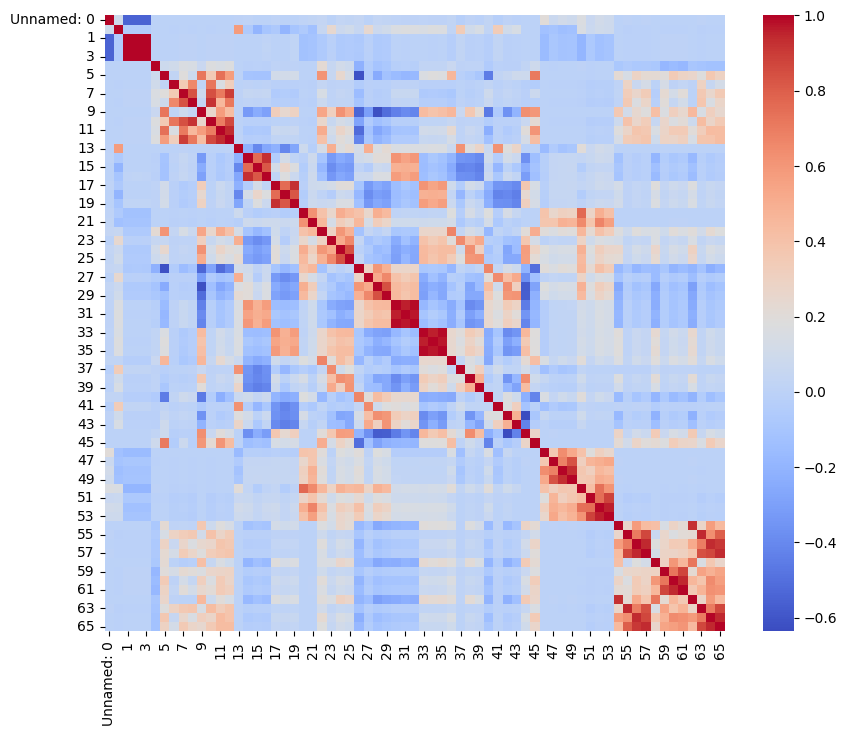

In [ ]:
# Get a correlation matrix and view it as a heatmap
def heatmap(data):
    correlation_matrix = data.corr()
    plt.figure(figsize =(10, 8))
    sns.heatmap(correlation_matrix, cmap='coolwarm')
    plt.show()
    return correlation_matrix

correlation_matrix = heatmap(X_train)

Corr(1, 2) = 0.9999505583247262
Corr(1, 3) = 0.9999917914669187
Corr(2, 1) = 0.9999505583247262
Corr(2, 3) = 0.99994247840194
Corr(3, 1) = 0.9999917914669187
Corr(3, 2) = 0.99994247840194
Corr(30, 32) = 0.9910744722200492
Corr(32, 30) = 0.9910744722200492
Corr(33, 35) = 0.9910533663305506
Corr(35, 33) = 0.9910533663305506


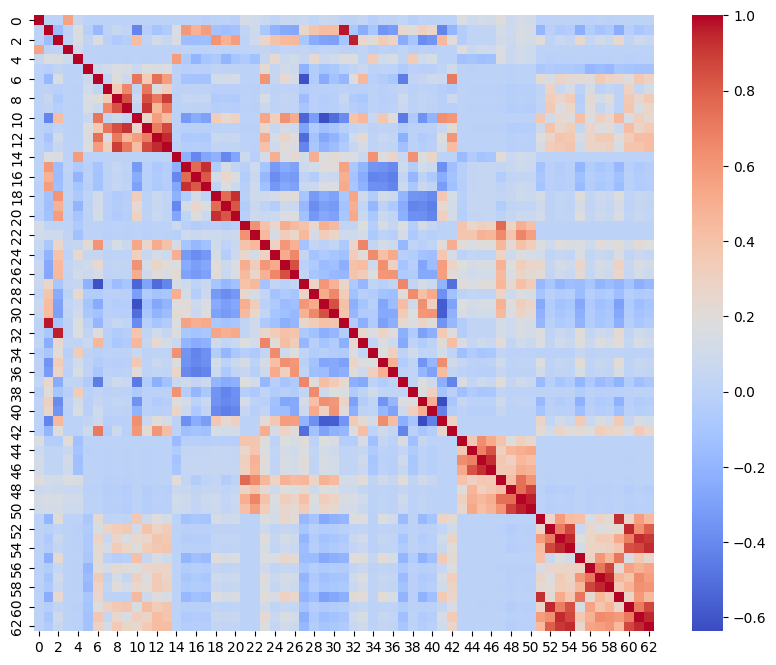

In [26]:
# A few off-diagonal reds, so let's see which ones they are
condition         = abs(correlation_matrix) > 1 - 1e-2
for row_index, row in condition.iterrows():
    for col_name, value in row.items():
        if value and row_index != col_name:
            print(f"Corr({row_index}, {col_name}) = {correlation_matrix.at[row_index, col_name]}")

# Hence, we want to condense (1,2,3), (30,32), and (33,35) using isolated PCA
def condense_dims(data, feats_list = [['1','2','3'],['30','32'],['33','35']], n = 1):
    old_cols      = []
    new_cols      = []
    for feats in feats_list:
        old_cols += feats
        pca       = PCA(n_components = n)
        new_cols.append(pca.fit_transform(data[feats]))
    new_cols.append(data.drop(old_cols, axis = 1, inplace = False).values)
    return pd.DataFrame(np.column_stack(new_cols))

X_train_reduced   = condense_dims(X_train)
k = heatmap(X_train_reduced)

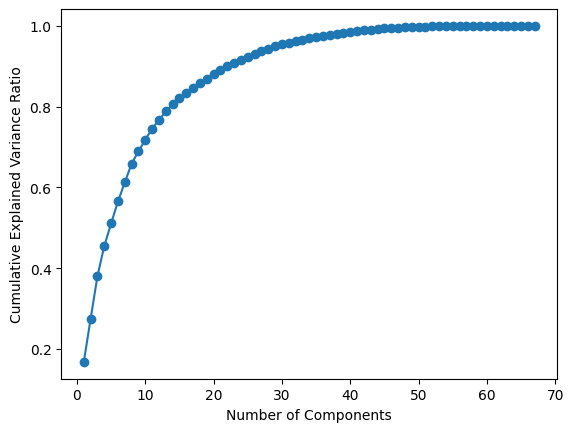

In [28]:
pca = PCA()
mean_train = X_train.mean()
std_train = X_train.std()
pca.fit((X_train - mean_train)/std_train)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [29]:
# Useful for later
PCA_20 = lambda data : condense_dims(data, feats_list = [data.columns.tolist()], n = 20)

# **Abstract Model Class and Accuracy Measure**

In [27]:
# General model class which we can use for the model factory
class model:

    # Sets the values of the common variables used for each model
    def base_setter(self, name, preprocess, scoring):
        self.preprocess                 = preprocess
        self.scoring                    = scoring
        self.name                       = name
        self.model                      = None
        self.save_path                  = f"drive/MyDrive/HFT_Researcher_Assessment/saved_models/{name}.pkl"

    # Abstract initializer
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)

    # Training and hyperparameter tuning stays the same across most models
    def train(self, X_train, y_train):
        X_train_pred                    = X_train.copy()
        X_train                         = self.preprocess(X_train)

        # For classifiers, we make target variable binary and encode magnitudes as sample weights
        sample_weights                  = None
        if 'classifier' in self.name:
          sample_weights                = abs(y_train) if 'KNN' not in self.name else None
          y_train                       = (y_train > 0).astype('int')

        # Check if model is already trained
        if os.path.exists(self.save_path):
            self.model                  = joblib.load(self.save_path)

        # Tune hyperparameters
        elif self.scoring:
            grid_search = GridSearchCV(
                             estimator  = self.model,
                             param_grid = self.param_grid,
                             scoring    = self.scoring
                          )
            if sample_weights is not None:
                grid_search.fit(X_train, y_train, sample_weight = sample_weights)
            else:
                grid_search.fit(X_train, y_train)
            self.model                  = grid_search.best_estimator_
            joblib.dump(self.model, self.save_path)

        # Fit model
        else:
            if sample_weights is not None:
                self.model.fit(X_train, y_train, sample_weight = sample_weights)
            else:
                self.model.fit(X_train, y_train)
            joblib.dump(self.model, self.save_path)

        return self.predict(X_train_pred)

    # Inference
    def predict(self, X):
        X                               = self.preprocess(X)
        return self.model.predict(X)

    # Naming
    def __repr__(self):
      return self.name

trained_models                          = {}

In [30]:
# PnL of any model
def PnL(y_pred, y_true):
    do_trades                           = (y_pred > 0)
    if len(do_trades.shape) == 2:
        do_trades = do_trades[:,0]
    return np.sum(y_true[do_trades])

# Run model inference and return PnL on train set, test set
def test_model(model):
    y_train_pred                        = model.predict(X_train)
    y_test_pred                         = model.predict(X_test)

    train_PnL                           = PnL(y_train_pred, y_train)
    test_PnL                            = PnL(y_test_pred, y_test)

    return train_PnL, test_PnL

train_PnL                               = {}
test_PnL                                = {}

# **Model Factory**

In [ ]:
# Some linear models for the factory

# Ridge regression
class ridge(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = Ridge()
        self.param_grid                 = [{'alpha': [10**n for n in range(-3, 3)]}]

# Lasso regression
class lasso(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = Lasso()
        self.param_grid                 = [{'alpha': [10**n for n in range(-3, 2)]}]

# Combination of ridge and lasso
class elasticnet(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = ElasticNet()
        self.param_grid                 = [{'alpha':    [10**n for n in range(-3, 3)]},
                                           {'l1_ratio': [10**n for n in range(-3, 2)]}]

In [31]:
# Some tree-based models

# XGboost for Regression on PnL
class xgboost(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = 'neg_mean_squared_error', objective = 'reg:squarederror'):
        self.base_setter(name, preprocess, scoring)
        self.model                      = xgb.XGBRegressor(objective = objective)
        self.param_grid                 = { 'max_depth': [3, 4, 5],
                                            'learning_rate': [1e-1, 1e-2, 1e-3],
                                            'n_estimators': [100, 200, 300] }

# XGboost for Classification of profitable trades
class xgboost_classifier(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = None):
        self.base_setter(name, preprocess, scoring)
        self.model                      = xgb.XGBClassifier()
        self.param_grid                 = { 'max_depth': [3, 4, 5],
                                            'learning_rate': [1e-1, 1e-2, 1e-3],
                                            'n_estimators': [100, 200, 300] }

# CatBoost for Classification of profitable trades
class catboost_classifier(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = None):
        self.base_setter(name, preprocess, scoring)
        self.model                      = CatBoostClassifier(verbose = 0)
        self.param_grid                 = { 'depth': [4, 6],
                                            'learning_rate': [0.01, 0.1],
                                            'l2_leaf_reg': [3], }

In [32]:
# Some other classifiers

class logreg_classifier(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = None):
        self.base_setter(name, preprocess, scoring)
        self.model                      = LogisticRegression()
        self.param_grid                 = { 'C': [0.1, 1],
                                            'max_iter': [100, 500],
                                            'penalty': ['l2'] }

class naivebayes_classifier(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = None):
        self.base_setter(name, preprocess, scoring)
        self.model                      = GaussianNB()
        self.param_grid                 = { 'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5] }

class SVC_classifier(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = None):
        self.base_setter(name, preprocess, scoring)
        self.model                      = SVC()
        self.param_grid                 = { 'C': [0.1, 1],
                                            'kernel': ['linear'] }

class KNN_classifier(model):
    def __init__(self, name, preprocess = lambda X : X, scoring = None):
        self.base_setter(name, preprocess, scoring)
        self.model                      = KNeighborsClassifier()
        self.param_grid                 = { 'n_neighbors': [3, 5, 7] }

In [33]:
# Now a neural network
class Dense_Neural_classifier(model):
    def __init__(self, name, preprocess = lambda X : X.values, scoring = None, n = 67, optimizer = 'Adam'):
        self.base_setter(name, preprocess, scoring)
        self.save_path                  = f"drive/MyDrive/HFT_Researcher_Assessment/saved_models/{name}.keras"
        self.model                      = Sequential([
                                              layers.Dense(128, activation='relu'),
                                              layers.Dropout(.2),
                                              layers.Dense(64, activation='relu'),
                                              layers.Dropout(.2),
                                              layers.Dense(32, activation='relu'),
                                              layers.Dropout(.2),
                                              layers.Dense(16, activation='relu'),
                                              layers.Dropout(.2),
                                              layers.Dense(1, activation='sigmoid')
                                          ])
        self.param_grid                 = None
        self.model.compile(optimizer    = optimizer,
                           loss         = 'binary_crossentropy')
        self.callbacks                  = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                                             patience=2, min_lr=0.0001)]
    def train(self, X_train, y_train):
        X_train_pred                    = X_train.copy()
        X_train                         = self.preprocess(X_train)
        if os.path.exists(self.save_path):
            self.model                  = keras.models.load_model(self.save_path)
        else:
            x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True)
            sample_weights                 = abs(y_train)
            y_train                        = (y_train > 0).astype('int')
            y_val                          = (y_val > 0).astype('int')
            self.model.fit(x_train, y_train,
                           epochs          = 10,
                           sample_weight   = sample_weights,
                           validation_data = (x_val, y_val),
                           callbacks       = self.callbacks)
            self.model.save(self.save_path)
    def predict(self, X):
        X                                = self.preprocess(X)
        return (self.model.predict(X) > 1e-3).astype(int)

# **Model PnL and Comparison**

In [34]:
models                                   = {}

# How much money would be made if we had a perfect model?
# i.e. with a future predicting crystal ball, how much money could be made?
models['crystal_ball_ideal']             = None
trained_models['crystal_ball_ideal']     = None
train_PnL['crystal_ball_ideal']          = np.sum(PnL(y_train, y_train))
test_PnL['crystal_ball_ideal']           = np.sum(PnL(y_test, y_test))

# What if we did every trade?
models['do_every_trade']                 = None
trained_models['do_every_trade']         = None
train_PnL['do_every_trade']              = np.sum(y_train)
test_PnL['do_every_trade']               = np.sum(y_test)

# Linear Models
models['elasticnet_no_preprocess']       = elasticnet
models['ridge_no_preprocess']            = ridge
models['ridge_PnL_scoring']              = lambda name : ridge(name, scoring = PnL)
models['lasso_no_preprocess']            = lasso

# Tree-based Models
models['xgboost_no_tuning']              = xgboost
models['xgboost_classifier_no_tuning']   = xgboost_classifier
models['catboost_classifier_no_tuning']  = catboost_classifier

# Some other classifiers
models['logreg_classifier_PCA']          = lambda name : logreg_classifier(name, scoring = accuracy_score, preprocess = PCA_20)
models['naivebayes_classifier_no_tuning']= naivebayes_classifier

# Takes too long, not worth it:
'''models['SVC_classifier_PCA']          = lambda name : SVC_classifier(name, scoring = accuracy_score, preprocess = PCA_20)
   models['KNN_classifier_PCA']          = lambda name : KNN_classifier(name, scoring = accuracy_score, preprocess = PCA_20)'''

# Neural Net
models['Dense_Neural_classifier_Adam']   = Dense_Neural_classifier
models['Dense_Neural_classifier_RMSprop']= lambda name : Dense_Neural_classifier(name, optimizer = 'RMSprop')

# Now since catboost was best, let's tune it to prevent overfitting
models['catboost_classifier_PCA_untuned']= lambda name : catboost_classifier(name, preprocess = PCA_20)
models['catboost_classifier_PCA']        = lambda name : catboost_classifier(name, scoring = accuracy_score, preprocess = PCA_20)
models['catboost_classifier_63d_untuned']= lambda name : catboost_classifier(name, preprocess = condense_dims)
models['catboost_classifier_63d']        = lambda name : catboost_classifier(name, scoring = accuracy_score, preprocess = condense_dims)

# Train-test loop for model factory
for i, name in enumerate(models.keys()):
    if not name in trained_models:
        temp                            = models[name](name)
        temp.train(X_train, y_train)
        trained_models[name]            = temp
    if not name in train_PnL:
        train_PnL[name], test_PnL[name] = test_model(trained_models[name])
    print(f'Model: {name}; Train PnL: {train_PnL[name]}; Test PnL: {test_PnL[name]}')

Model: crystal_ball_ideal; Train PnL: 195.6927566509; Test PnL: 55.96225182400002
Model: do_every_trade; Train PnL: -1.6064849640999856; Test PnL: -1.3011567398
Model: elasticnet_no_preprocess; Train PnL: 2.3464665609999997; Test PnL: -0.5698679990000001
Model: ridge_no_preprocess; Train PnL: 23.4148709815; Test PnL: 3.6519402642
Model: ridge_PnL_scoring; Train PnL: 23.313238563500004; Test PnL: 3.6014015462
Model: lasso_no_preprocess; Train PnL: 2.3058292180000004; Test PnL: -0.08494930499999992
Model: xgboost_no_tuning; Train PnL: 85.4131365811; Test PnL: 2.3331689181999993
Model: xgboost_classifier_no_tuning; Train PnL: 82.11714784210001; Test PnL: 4.292366797200001
Model: catboost_classifier_no_tuning; Train PnL: 123.60621472049999; Test PnL: 4.2972789131999996
Model: logreg_classifier_PCA; Train PnL: 2.9270169980000147; Test PnL: -0.7500738138
Model: naivebayes_classifier_no_tuning; Train PnL: -0.35180087509998514; Test PnL: -1.1157400037999998
616/616 [===========================

# **Results Visualization**

(-11.471447044849986, 205.55771873165)

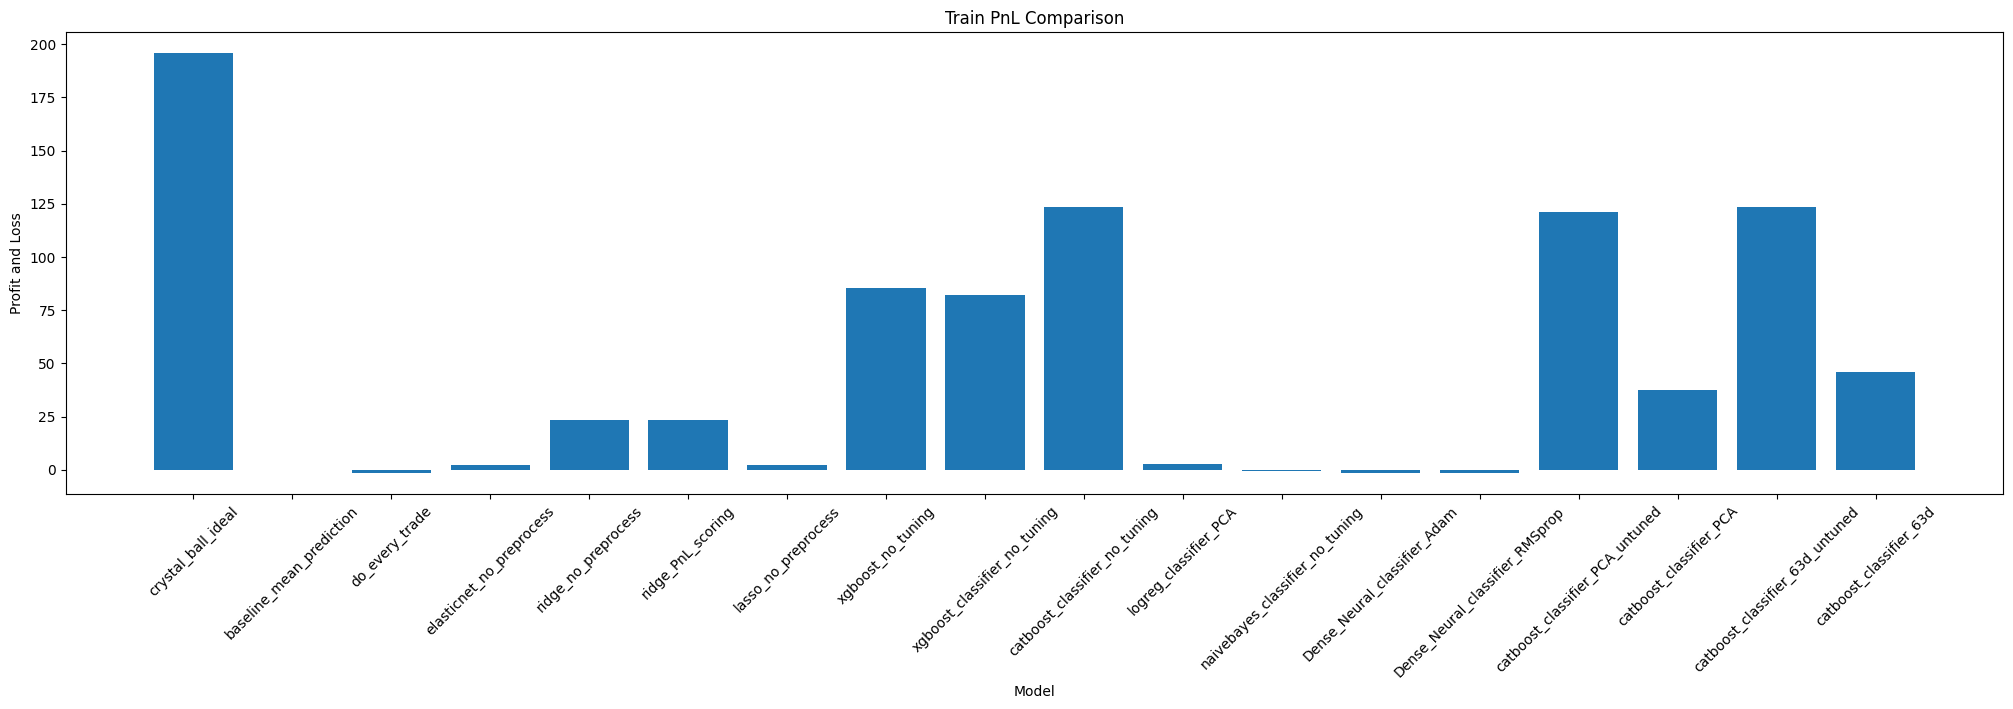

In [ ]:
train_pnl_arr  = [train_PnL[i] for i in models.keys()]
plt.figure(figsize = (25,6))
plt.bar(models.keys(), train_pnl_arr)
plt.xlabel('Model')
plt.ylabel('Profit and Loss')
plt.title('Train PnL Comparison')
plt.xticks(rotation=45)
plt.ylim()

(-4.175548763900001, 58.82595661390002)

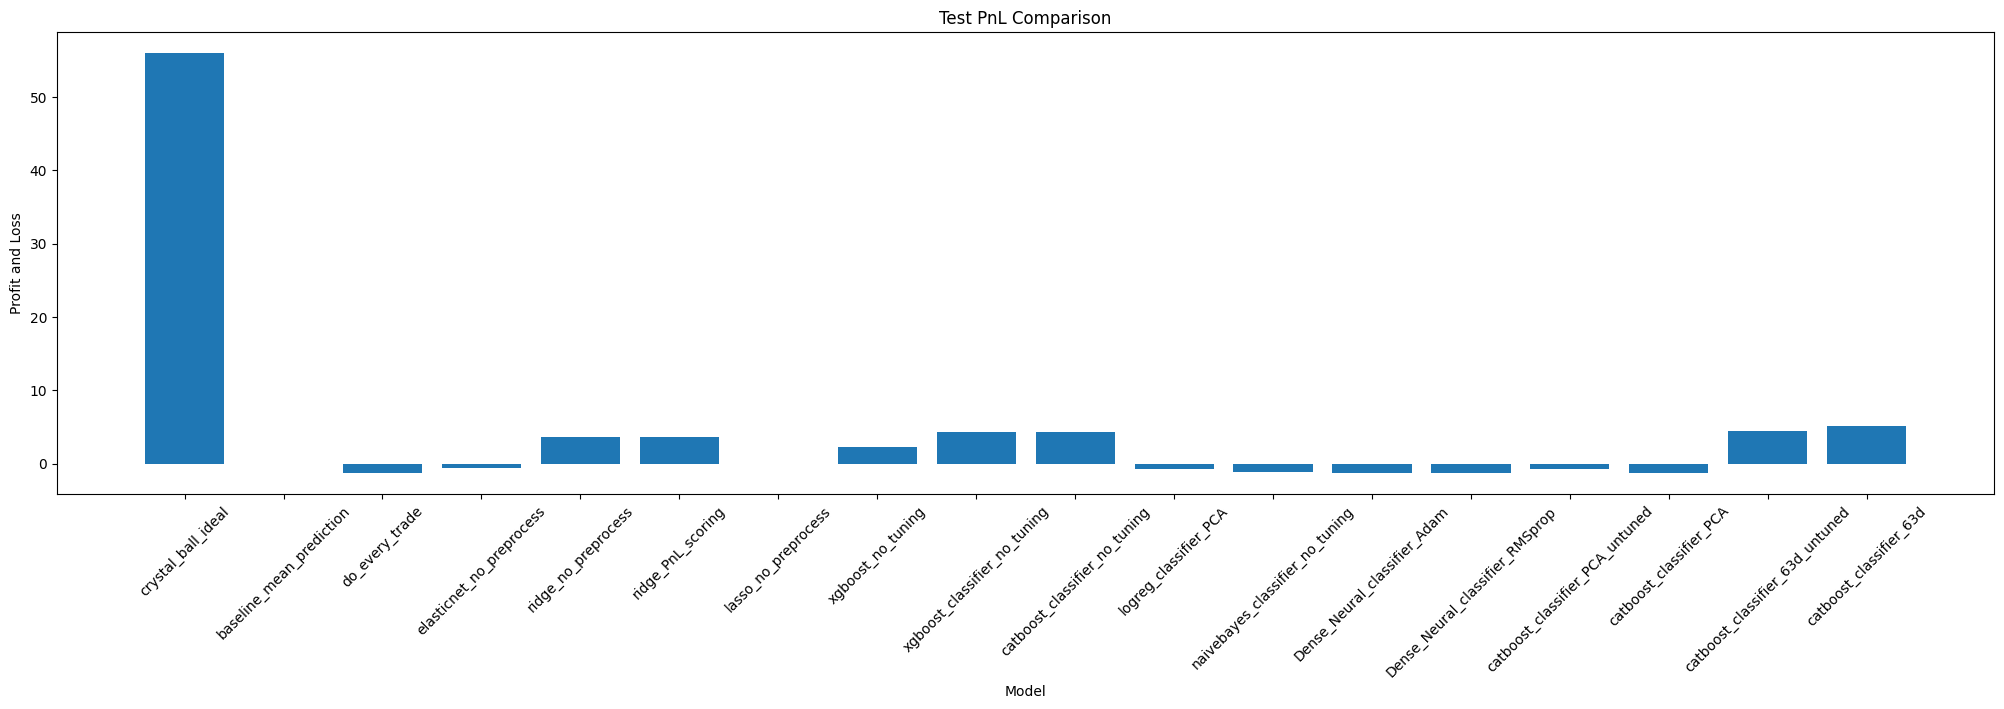

In [ ]:
test_pnl_arr   = [test_PnL[i] for i in models.keys()]
plt.figure(figsize = (25,6))
plt.bar(models.keys(), test_pnl_arr)
plt.xlabel('Model')
plt.ylabel('Profit and Loss')
plt.title('Test PnL Comparison')
plt.xticks(rotation=45)
plt.ylim()

# **Conclusion**
- The dataset is extremely noisy, and most models perform poorly on it.
- I tried the whole pipeline with normalization on the data, and some models had slightly better performance but Catboost was still the best, and Catboost performed better with unnormalized data (both train and test).
- The objective was to "predict" the target variable, but classifiers performed strictly better in most cases.
- Catboost with reduced (63-dimensional) data and hyperparameter tuning performed the best, and made 5.192 units of profit on the test set, where the trivial model (do_every_trade) made -1.301, and the ideal model (crystal_ball_ideal) made 55.962.
- Given more time, I would explore time-series models and also other decision tree based models, like state of the art iterations of random forest ensemble techniques beyong xgboost and catboost.